# Maximum Depth Band classifier using confidence bands

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sampling_functions import *
from utils_PH import compute_single_parameter_landscape, compute_multiparameter_landscape
from plotting import plot_confidence_band_multi
from confidence_bands import standard_bootstrap, multiplier_bootstrap, compute_accuracy

[KeOps] Warning : cuda was detected, but driver API could not be initialized. Switching to cpu only.


In [2]:
num_samples = 100
R, r = 3.0, 0.7
num_points = 500
ks = 3
resolution = 100
hom_degree = 1
threshold_radius = 0.5
box = [[0,0.7], [0.5,1.7]]

## Generate dataset

In [3]:
for type in ['sphere', 'torus', 'klein']:
    single_landscapes = np.empty((num_samples, ks, resolution))
    multi_landscapes = np.empty((num_samples, ks, resolution, resolution))

    for i in tqdm(range(num_samples)):
        # Sample points
        if type == 'torus':
            points = sample_torus(R, r, num_points)
        elif type == 'sphere':
            points = sample_sphere(R, num_points)
        elif type == 'klein':
            points = sample_klein_bottle(num_points)

        # Add noise and normalize
        points = add_gaussian_noise(points, noise_level=0.1)
        points = add_salt_and_pepper_noise(points, fraction=0.5, amount=0.5)
        points = normalize_point_cloud(points)
        
        # Compute landscapes
        single_landscapes[i,:,:] = compute_single_parameter_landscape(points, hom_degree=1, ks=ks, resolution=resolution, sample_range=[0, 0.5])
        multi_landscapes[i,:,:,:] = compute_multiparameter_landscape(points, bandwidth=0.5, threshold_radius=threshold_radius, hom_degree=hom_degree, ks=ks, resolution=resolution, box=box)
    
    if type == 'torus':
        single_landscapes_torus = single_landscapes
        multi_landscapes_torus = multi_landscapes
    elif type == 'sphere':
        single_landscapes_sphere = single_landscapes
        multi_landscapes_sphere = multi_landscapes
    elif type == 'klein':
        single_landscapes_klein = single_landscapes
        multi_landscapes_klein = multi_landscapes


100%|██████████| 100/100 [04:04<00:00,  2.44s/it]


## Plot confidence bands

/mnt/c/code/bands-mph-landscapes/plotting.py:80: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


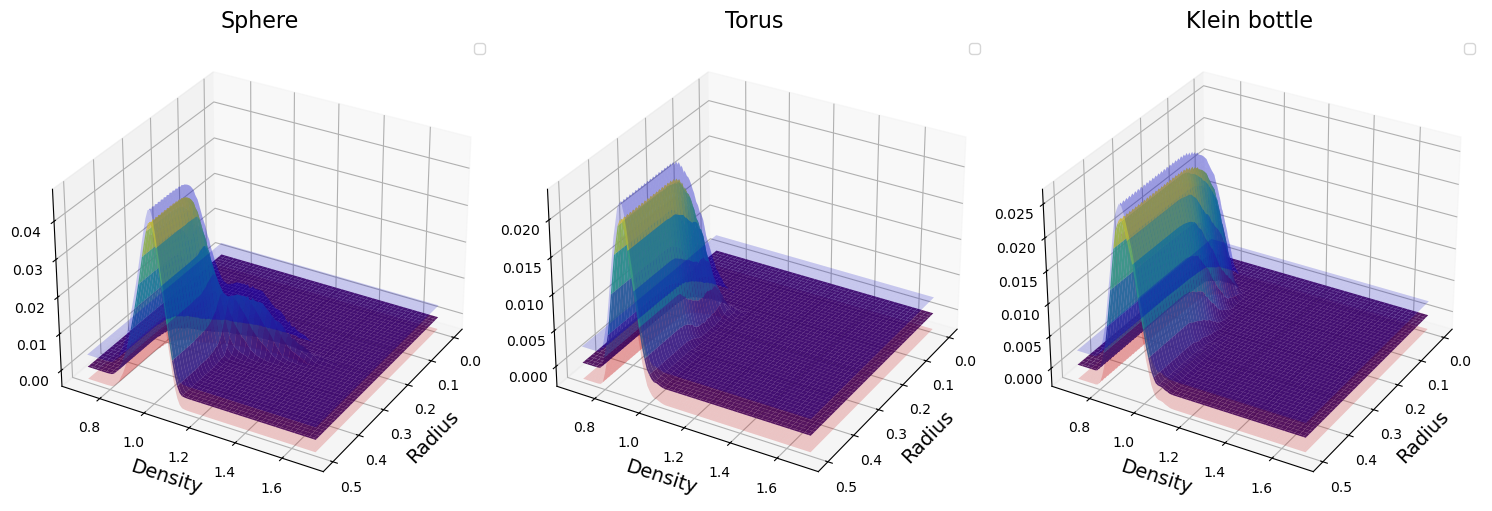

In [4]:
fig = plt.figure(figsize=(15, 5))
for type in ['sphere', 'torus', 'Klein bottle']:
    if type == 'sphere':
        ax = fig.add_subplot(131, projection='3d')
        plot_confidence_band_multi(landscapes=multi_landscapes_sphere,box=box,ax=ax)
        ax.set_title("Sphere", fontsize = 16)
    if type == 'torus':
        ax = fig.add_subplot(132, projection='3d')
        plot_confidence_band_multi(landscapes=multi_landscapes_torus,box=box,ax=ax)
        ax.set_title("Torus", fontsize = 16)
    if type == 'Klein bottle':
        ax = fig.add_subplot(133, projection='3d')
        plot_confidence_band_multi(landscapes=multi_landscapes_klein,box=box,ax=ax)
        ax.set_title("Klein bottle", fontsize = 16)
plt.tight_layout()
plt.show()

## MBD classifier

In [5]:
# Generate labels and put together all landscapes
labels = np.repeat(np.arange(3), num_samples)
single_landscapes = np.vstack((single_landscapes_sphere, single_landscapes_torus, single_landscapes_klein))
multi_landscapes = np.vstack((multi_landscapes_sphere, multi_landscapes_torus, multi_landscapes_klein))

print(f'Shape of the single-parameter landscapes: {single_landscapes.shape}')
print(f'Shape of the multiparameter landscapes: {multi_landscapes.shape}')

Shape of the single-parameter landscapes: (300, 3, 100)
Shape of the multiparameter landscapes: (300, 3, 100, 100)


In [6]:
# Evaluate MBD classifier with 5-fold validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = {"single_bcb": [], "single_mcb": [], "multi_bcb": [], "multi_mcb": []}

for train_idx, test_idx in kf.split(labels):
    train_label, test_label = labels[train_idx], labels[test_idx]
    single_mpl_train, single_mpl_test = single_landscapes[train_idx, 0, :], single_landscapes[test_idx, 0, :]
    multi_mpl_train, multi_mpl_test = multi_landscapes[train_idx, 0, :, :], multi_landscapes[test_idx, 0, :, :]

    single_bcb, single_mcb = [], []
    multi_bcb, multi_mcb = [], []

    for i in range(3):
        single_correct_landscapes = single_mpl_train[train_label == i]
        ln, _, un = standard_bootstrap(single_correct_landscapes, alpha=0.05, B=1000)
        single_bcb.append([ln, un])
        
        ln, _, un = multiplier_bootstrap(single_correct_landscapes, alpha=0.05, B=1000)
        single_mcb.append([ln, un])

        multi_correct_landscapes = multi_mpl_train[train_label == i]
        ln, _, un = standard_bootstrap(multi_correct_landscapes, alpha=0.05, B=1000)
        multi_bcb.append([ln, un])
        
        ln, _, un = multiplier_bootstrap(multi_correct_landscapes, alpha=0.05, B=1000, multiparameter=True)
        multi_mcb.append([ln, un])


    accuracies["single_bcb"].append(compute_accuracy(single_mpl_test, test_label, single_bcb))
    accuracies["single_mcb"].append(compute_accuracy(single_mpl_test, test_label, single_mcb))
    accuracies["multi_bcb"].append(compute_accuracy(multi_mpl_test, test_label, multi_bcb))
    accuracies["multi_mcb"].append(compute_accuracy(multi_mpl_test, test_label, multi_mcb))

for method, acc_list in accuracies.items():
    print(f"Mean accuracy with {method}: {np.mean(acc_list):.4f} (±{np.std(acc_list):.4f})")

Mean accuracy with single_bcb: 0.9800 (±0.0125)
Mean accuracy with single_mcb: 0.9533 (±0.0125)
Mean accuracy with multi_bcb: 1.0000 (±0.0000)
Mean accuracy with multi_mcb: 1.0000 (±0.0000)
